# Simulation study: The effect of misclassification on mutual information.

During the UNSEEN study, we will calculate the mutual information between a feature set and a variable representing the caseness of complex mental health difficulties. Our calculated mutual information assumes that the feature set and caseness are observed with perfect fidelity. On the contrary, a motivation of the UNSEEN study is the idea that many patient features are under-recorded in their electronic healthcare records. Therefore, we want to know how sensitive our calculated mutual information is to various degrees of under-recording of features.

## Study question.

The question I am asking is _What is the relationship between the degree of missclassification and scaled mutual information?_

An answer will be be provided as a narrative description of the trend in scaled mutual information with respect to:
1. increasing random misclassification.
2. increasing selective misclassification.

The narrative description will incorporate comment on the uncertainty in the trend due to a range of feature-set prevalence and the degress to which the feature set conincides with the caseness variables.

## Study design.

This simulation study varies three parameters that affect the mutual information between a feature-set variable and a caseness variable:
1. Feature-set prevalence (as a proportion of the caseness prevelance).
2. The degree to which the feature-set conincides - or overlaps - with the caseness variables.
3. The degree of misclassification.

### Feature-set prevalence.
I will study seven feature-set prevalence values, each defined with respect to the fixed prevelance of the caseness variable: {0.1x caseness, 0.25x caseness, 0.5x caseness, 1.0x caseness, 2.0x caseness, 4.0x caseness, 8.0x caseness}.

### Degree of overlap.
I will study three degrees of overlap in positives, defined with respect to the variable of lesser prevalence: {None, Half, Maximum}.
- "None" overlap equates to no patient having both the feature set and caseness variable. In these scenarios, there are zero true positives, as many false positives as there are patients with the feature set, as many true negatives as patients without the caseness minus the count of false positives, and zero false negatives.
- "Half" overlap equates to either only half the patients with the feature set also having the caseness, or half the patients with the caseness having the feature set. The variable with the smaller count will be halved.
- "Maximum" overlap equates to either all the patients with the feature set also having the caseness, or all the patients with the caseness having the feature set. The variable with the smaller count will be used.

### Degree of misclassification.
I will study two regimes of misclassification (random misclassification and selective misclassification) at four degrees (10%, 25%, 50%, 75%).

In the random-misclassification regime, a proportion of the patients will be randomly selected and their presence/absence value for the feature set will be switched.

In the selective-misclassification regime, a proportion of the patients with the feature set vector be randomly selected and changed to not have the feature set. In other words, a portion of true positives become false negatives. This represents the assumption that the true prevalence of features is under-recorded in electronic healthcare records. 

## Imports.

In [333]:
library(tidyverse)

## Parameter values.

In [334]:
# Count of patients.
n_patients = 200000

# Set of parameter values for feature-set prevalence.
# ## Each is a scalar multiplier.
prev <- c(0.1, 0.25, 0.5, 1, 2, 4, 8)

# Set of parameter values for the degree of overlap.
# ## Each is a scalar multiplier.
degr_overlap <- c("none", "half", "maximum")

# Set of parameter values for the misclassification regime.
mr <- c("random", "selective")

# Set of parameter values for the degree misclassification.
degr_misclassif <- c(0, 0.1, 0.25, 0.5, 0.75)

# Set caseness variable.
caseness_prevalence <- 0.04
n_caseness <- n_patients * caseness_prevalence
caseness <- c(rep(1, n_caseness), rep(0, n_patients - n_caseness) )

# Calculate caseness entropy.
pk <- table(caseness) / length(caseness)
entropy_c <- -sum(pk * log(pk) )

## Functions.

In [335]:
# Calculate the mutual information.
calcMI <- function(tp, fp, tn, fn, n)
    {
    # Add tiny amount of noise to 0-valued inputs to prevent numeric problems.
    tp <- if (tp == 0) 1e-10 else tp
    fp <- if (fp == 0) 1e-10 else fp
    tn <- if (tn == 0) 1e-10 else tn
    fn <- if (fn == 0) 1e-10 else fn
        
    # Calculate the entropy of caseness variable.
    entropy_c <- -( sum(tp, fn) / n) * log( sum(tp ,fn) / n ) - ( sum(fp, tn) / n) * log( sum(fp, tn) / n)
    
    # Calculate the entropy of the feature set.
    entropy_fs <- -( sum(tp, fp) / n) * log( sum(tp ,fp) / n ) - ( sum(fn, tn) / n) * log( sum(fn, tn) / n)
    
    # Calculate the joint entropy of the feature set and caseness variable.
    entropy_fsC <- 
        - sum(
            (tp / n) * log(tp / n),
            (fp / n) * log(fp / n),
            (fn / n) * log(fn / n),
            (tn / n) * log(tn / n)
        )
    
    # Calculate the scaled mutual information.
    MI <- entropy_fs + entropy_c - entropy_fsC
    sMI <- MI / entropy_c
    
    return(sMI)
}

## Simulate.

In [336]:
# Set storage.
df_output <- data.frame(
    prev = numeric(),
    overlap = numeric(),
    mr = numeric(),
    misclassif = numeric(),
    MI = numeric(),
    tp_observed = numeric(),
    fp_observed = numeric(),
    tn_observed = numeric(),
    fn_observed = numeric(),
    sum = numeric()
)

# Set counter
counter = 1

# Run simulation.
for (i_prev in 1:length(prev) )
{
    # Set prevalence.
    fs_prev <- prev[i_prev]
    n_fs <- round(n_caseness*fs_prev)
    
    for (i_overlap in 1:length(degr_overlap) )
    {
        # Set overlap
        fs_overlap <- degr_overlap[i_overlap]

        # Create 'actual' contingency table.
        if (fs_overlap == "none")
            {
            tp_actual <- 0
            fp_actual <- n_fs
            tn_actual <- n_patients - n_caseness - n_fs
            fn_actual <- n_caseness
        } else if (fs_overlap == "half")
            {
            tp_actual <- if ( (n_fs / 2) < (n_caseness / 2) ) (n_fs / 2) else (n_caseness / 2)
            fp_actual <- if ( (n_fs / 2) < (n_caseness / 2) ) (n_fs / 2) else (n_fs - (n_caseness / 2) )
            tn_actual <- if ( (n_fs / 2) < (n_caseness / 2) ) (n_patients - n_caseness - (n_fs / 2) ) else (n_patients - n_caseness - n_fs + (n_caseness / 2) )
            fn_actual <- if ( (n_fs / 2) < (n_caseness / 2) ) (n_caseness - (n_fs / 2) ) else (n_caseness / 2)
        } else if (fs_overlap == "maximum")
            {
            tp_actual <- min(n_fs, n_caseness)
            fp_actual <- if (n_fs < n_caseness) 0 else (n_fs - n_caseness)
            tn_actual <- if (n_fs < n_caseness) (n_patients - n_caseness) else (n_patients - n_fs)
            fn_actual <- if (n_fs < n_caseness) (n_caseness - n_fs) else 0
        }
        
        # Check that the sums add up.
        if (sum(tp_actual, fp_actual, tn_actual, fn_actual) != n_patients){c(tp_actual, fp_actual, tn_actual, fn_actual); break}

        for (i_mr in 1:length(mr) )
        {
            # Set misclassification regime.
            fs_mr <- mr[i_mr]
            
            for (i_misclassif in 1:length(degr_misclassif) )
            {
                # Set degree of misclassification.
                fs_misclassif <- degr_misclassif[i_misclassif]
                # Create 'observed' contingency table.
                if (fs_mr == "random")
                    {
                    # Build feature-set and caseness vectors from the 'actual' contingency table.
                    row_options <- data.frame(fs = c(0,0,1,1), c = c(0,1,0,1) )
                    #print(c(fs_prev, fs_overlap, fs_mr, fs_misclassif, tp_actual, fp_actual, tn_actual, fn_actual, sum(tp_actual, fp_actual, tn_actual, fn_actual) ) )
                    actual_array <- row_options[c( rep(1, tn_actual), rep(2, fn_actual), rep(3, fp_actual), rep(4, tp_actual) ), ]

                    # Randomly misclassify `misclassif`-many elements of the feature-set vector.
                    if (fs_misclassif != 0)
                        {
                        idx_to_misclassify <- sample(c(1:n_patients), round(fs_misclassif * n_patients) )
                        actual_array[idx_to_misclassify, 1] <- 1 - actual_array[idx_to_misclassify, 1]
                    }

                    # Recalculate the cells of the contingency table.
                    tp_observed <- actual_array %>% dplyr::filter(fs == 1 & c == 1) %>% nrow()
                    fp_observed <- actual_array %>% dplyr::filter(fs == 1 & c == 0) %>% nrow()
                    tn_observed <- actual_array %>% dplyr::filter(fs == 0 & c == 0) %>% nrow()
                    fn_observed <- actual_array %>% dplyr::filter(fs == 0 & c == 1) %>% nrow()

                }else if (fs_mr == "selective")
                    {
                    tp_observed <- tp_actual - round(tp_actual * fs_misclassif)
                    fp_observed <- fp_actual
                    tn_observed <- tn_actual
                    fn_observed <- fn_actual + round(tp_actual * fs_misclassif)
                }

                # Calculate the scaled mutual information.
                sMI <- calcMI(tp_observed, fp_observed, tn_observed, fn_observed, n_patients)

                # Collect the values for this scenario.
                df_output <- rbind(df_output, data.frame(fs_prev, fs_overlap, fs_mr, fs_misclassif, sMI) )

                # Iterate counter.
                counter = counter + 1
            }
        }
    }
}

## Plot.

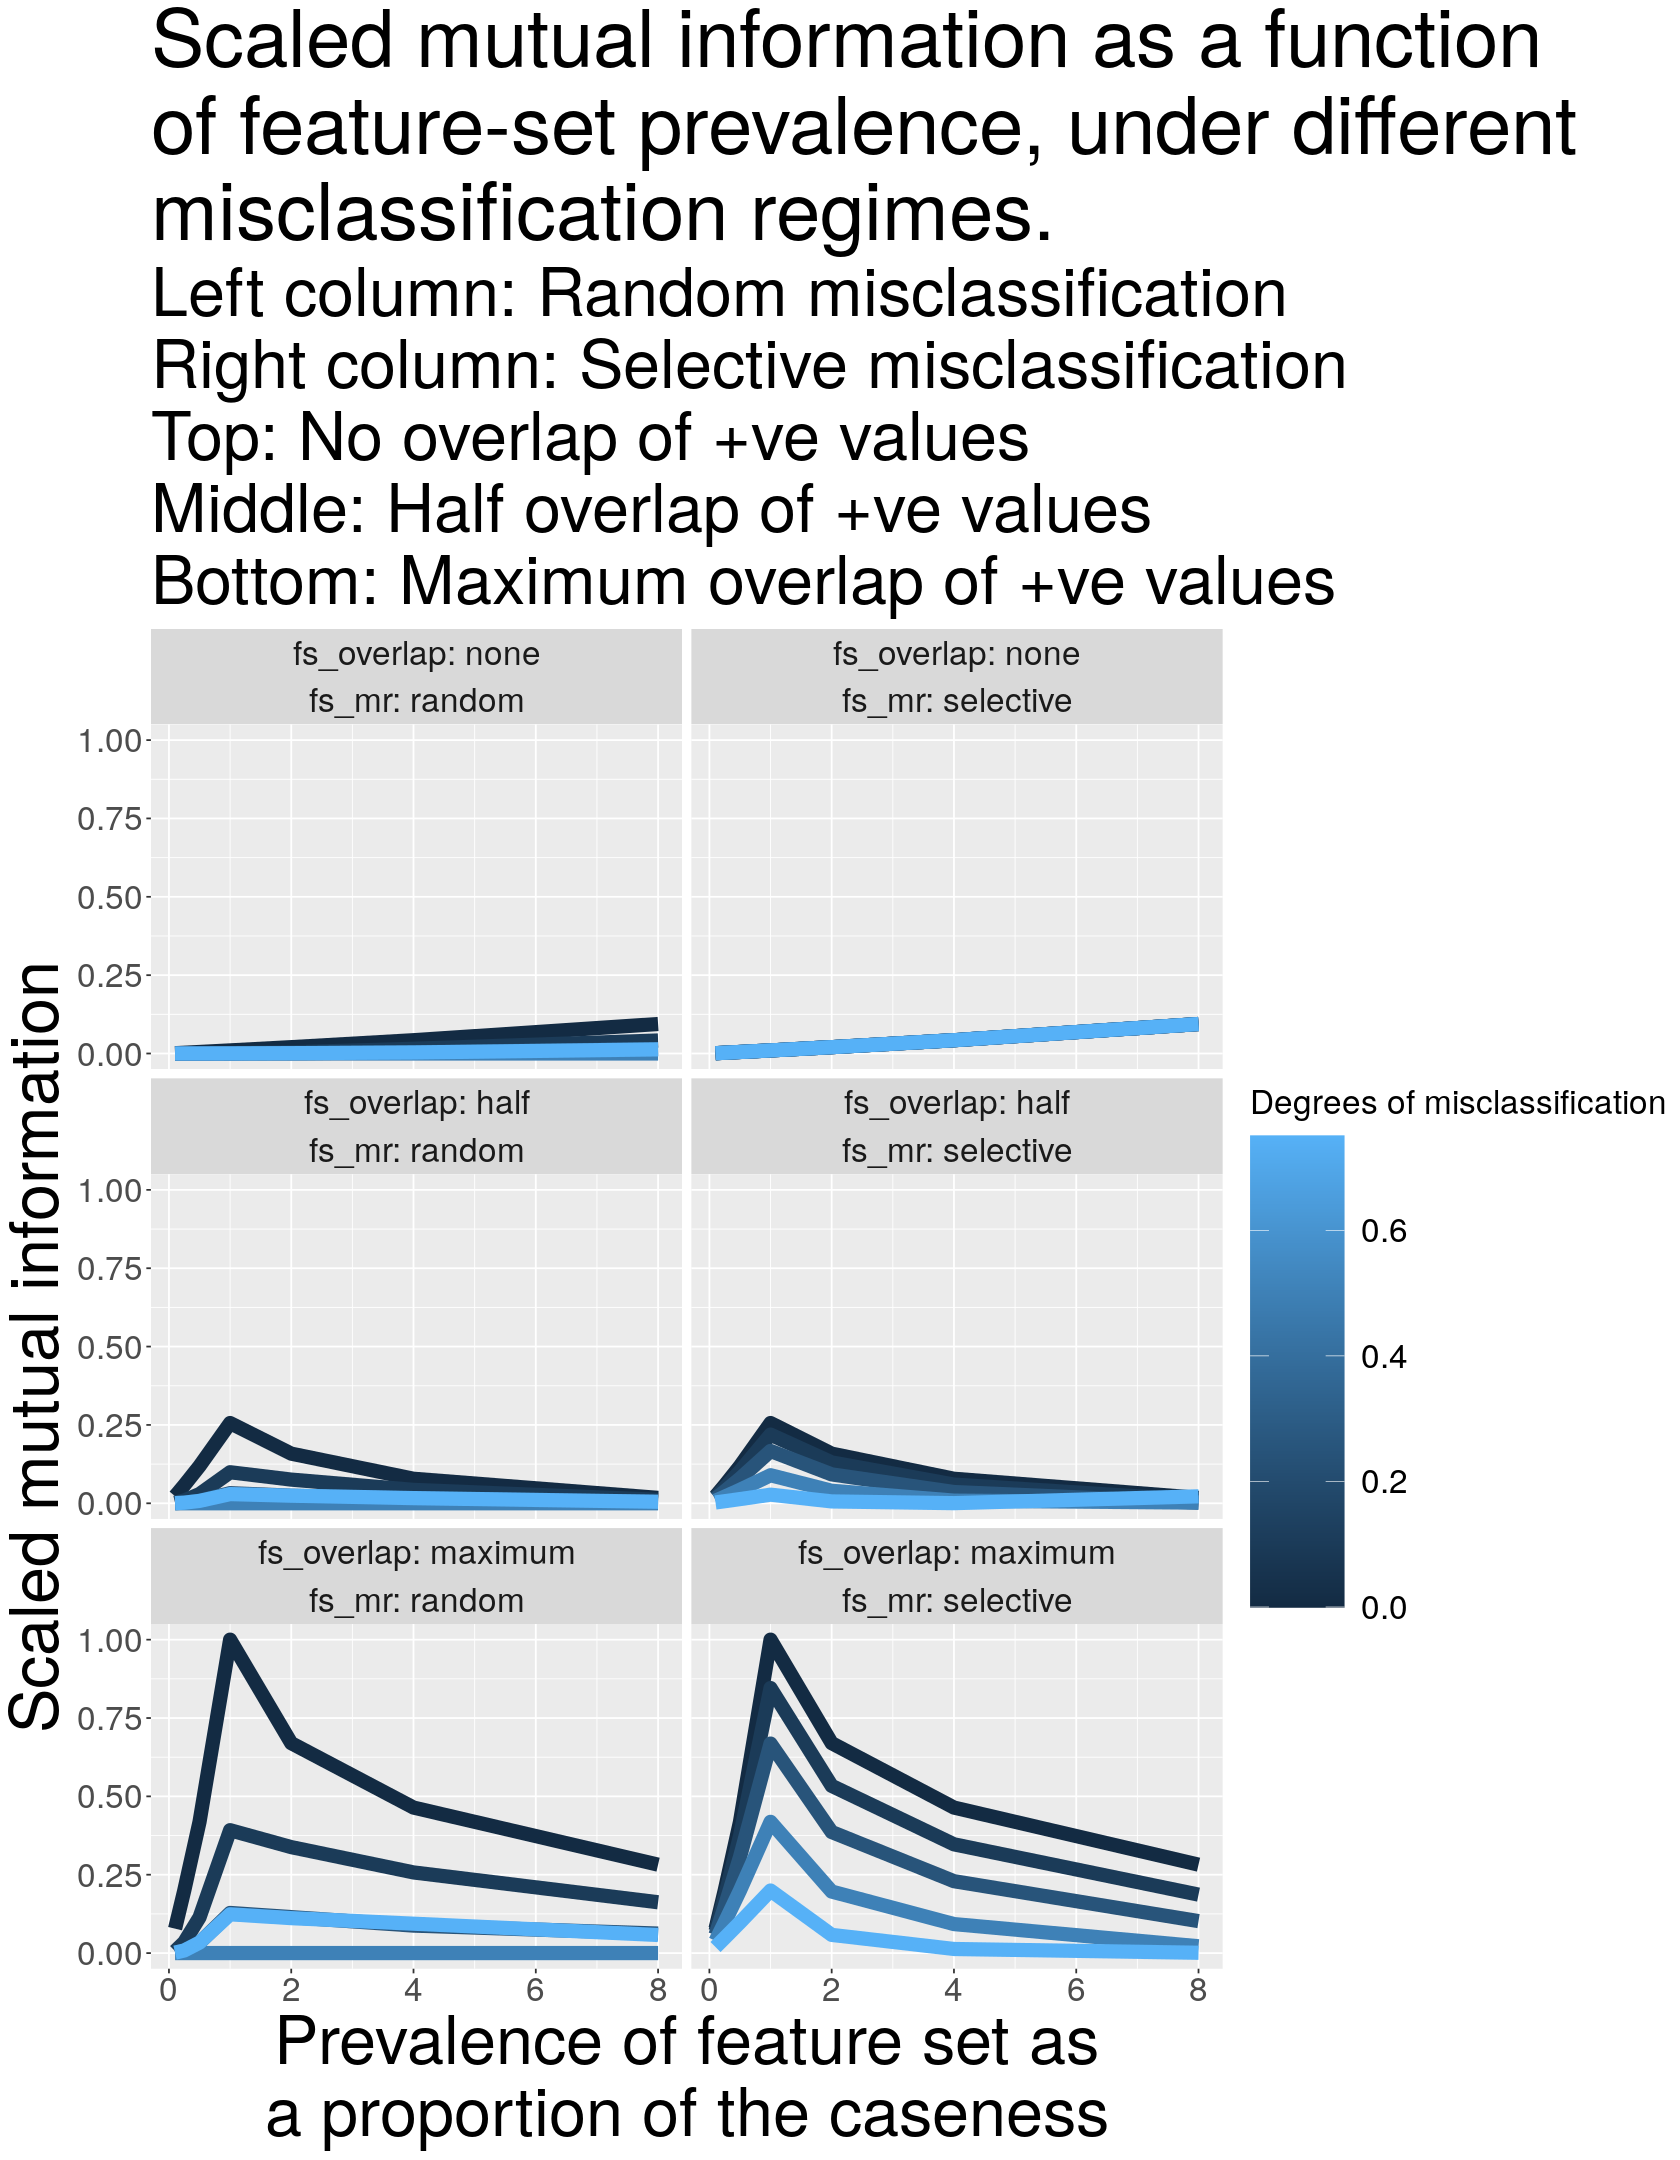

In [337]:
options(repr.plot.width = 14, repr.plot.height = 18)

df_output$fs_overlap <- factor(df_output$fs_overlap, levels = c("none", "half", "maximum"))

df_output %>%
ggplot() +
geom_line(aes(x = fs_prev, y = sMI, group = fs_misclassif, color = fs_misclassif), linewidth = 4) +
facet_wrap(vars(fs_overlap, fs_mr), ncol = 2, labeller = label_both) +
scale_colour_continuous(name = "Degrees of misclassification") +
#scale_colour_gradient(limits = c(0, 1), 
#                      breaks = c(0, 0.1, 0.25, 0.5, 0.75),
#                      labels = c(0, 0.1, 0.25, 0.5, 0.75))
labs(x = "Prevalence of feature set as\na proportion of the caseness"
    ,y = "Scaled mutual information"
    ,title = "Scaled mutual information as a function\nof feature-set prevalence, under different\nmisclassification regimes."
    ,subtitle = paste0("Left column: Random misclassification\nRight column: Selective misclassification\n"
                      ,"Top: No overlap of +ve values\nMiddle: Half overlap of +ve values\nBottom: Maximum overlap of +ve values")) +
theme(
    title = element_text(size = 40),
     strip.text.x = element_text(size = 20),
     axis.text = element_text(size = 20),
     axis.title = element_text(size = 40),
     legend.key.size = unit(2, 'cm'),
     legend.title = element_text(size = 20),
     legend.text = element_text(size = 20))

## Interpretation.

1. When there is no overlap in the positive values of the feature-set and caseness variable (top row)...
    - scaled mutual information is small across the reasonable range of feature-set prevelance.
    - scaled mutual information is slightly more affected by random misclassification than by selective misclassification.
2. When there is at least some overlap in the positive values of the feature-set and the caseness variable (middle and top row)...
    - scaled mutual information decreases as the prevelance of the feature set moves away from the prevelance of the caseness variable.
    - scaled mutual information is attenuated proportionally to the degree of misclassification.
        - Note: there is an exception for the 50% random misclassification when there is maximum overlap of positive values.
    - the degree of attenuation due to misclassification is greater for random misclassification than for selective misclassification.
    